# Capstone project: Function 8

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,RationalQuadratic, Matern, WhiteKernel
import matplotlib.pyplot as plt
import sklearn
from IPython.display import clear_output
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plotting
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler
from bayes_opt import BayesianOptimization

/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'bayes_opt'

## Function 8 description

You’re optimising an eight-dimensional black-box function, where each of the eight input parameters affects the output, but the internal mechanics are unknown. 

Your objective is to find the parameter combination that maximises the function’s output, such as performance, efficiency or validation accuracy. Because the function is high-dimensional and likely complex, global optimisation is hard, so identifying strong local maxima is often a practical strategy.

For example, imagine you’re tuning an ML model with eight hyperparameters: learning rate, batch size, number of layers, dropout rate, regularisation strength, activation function (numerically encoded), optimiser type (encoded) and initial weight range. Each input set returns a single validation accuracy score between 0 and 1. Your goal is to maximise this score.

Input array 8D (40,8) output array 1D (40,1)

### Step 1: Load data

In [3]:
X = np.load('initial_inputs.npy')
y = np.load('initial_outputs.npy')

inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

print(X,y)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

### Step 2: Fit a surrogate model - Gaussian process

In [4]:
kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(X, y)

GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=2.5),
                         normalize_y=True)

### Step 3: Define prediction function for BO and give parameter space

In [5]:
def gp_predict(x1, x2, x3, x4, x5, x6, x7, x8):
    X_new = np.array([[x1, x2, x3, x4, x5, x6, x7, x8]])
    mu = gp.predict(X_new)[0]
    return mu  # maximise performance

pbounds = {
    'x1': (0, 1),
    'x2': (0, 1),
    'x3': (0, 1),
    'x4': (0, 1),
    'x5': (0, 1),
    'x6': (0, 1),
    'x7': (0, 1),
    'x8': (0, 1)
}

### Step 4: Initialise acquisition function and run BO

In [6]:
optimizer = BayesianOptimization(
    f=gp_predict,        # surrogate function to optimise
    pbounds=pbounds,     # search space
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=0,       # use only model-based exploration
    n_iter=10            # suggest 10 new hyperparameter sets
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 7.6761681 | 0.3745401 | 0.9507143 | 0.7319939 | 0.5986584 | 0.1560186 | 0.1559945 | 0.0580836 | 0.8661761 |
| 2         | 7.1653448 | 1.0       | 0.0       | -.400e-18 | 0.0       | 1.0       | 1.0       | 1.0       | 0.0       |
| 3         | 7.7706330 | 0.4362734 | 0.0535534 | 0.5351936 | 0.7080350 | 0.8530202 | 0.6104665 | 0.9738062 | 0.6338490 |
| 4         | 6.5531805 | 0.8302373 | 0.0022303 | 0.8410091 | 0.2668357 | 0.4449538 | 0.1748114 | 0.9143577 | 0.4281315 |
| 5         | 7.7866161 | 0.3512130 | 0.9239929 | 0.7054644 | 0.6183917 | 0.0548505 | 0.2936318 | 0.1031162 | 0.7288570 |
| 6         | 8.3889447 | 0.1631850 | 0.3778688 | 0.4365867 | 0.9533749 | 0.8013764 | 0.7455001 | 0.7143209 | 0.7952493 |
| 7         | 8.2742060 

### Step 5: Identify next logical parameters to try


Best combination found:
{'target': np.float64(9.02714440899356), 'params': {'x1': np.float64(0.0), 'x2': np.float64(0.38898383302592415), 'x3': np.float64(0.0), 'x4': np.float64(1.0), 'x5': np.float64(1.0), 'x6': np.float64(1.0), 'x7': np.float64(0.0), 'x8': np.float64(0.0)}}


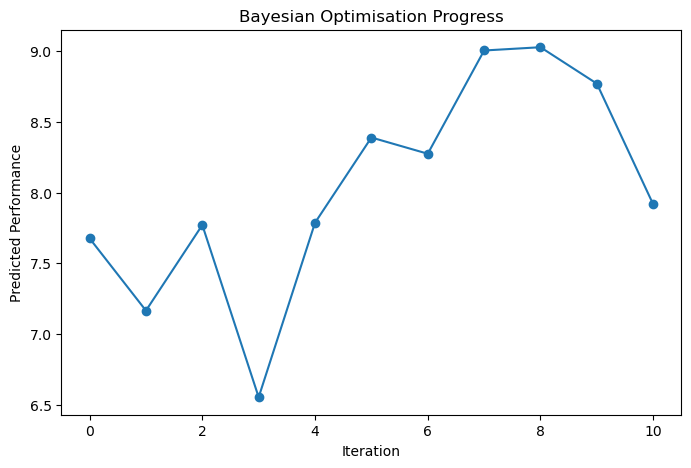

In [8]:
print("\nBest combination found:")
print(optimizer.max)

#Plot optimisation progress
scores = [res["target"] for res in optimizer.res]
plt.figure(figsize=(8,5))
plt.plot(scores, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Predicted Performance")
plt.title("Bayesian Optimisation Progress")
plt.show()

# ********* Week 2 data update and optimisation *************

## Step 1: Load in updated data

In [2]:
inputdata = np.load('initial_inputs.npy')
outputdata = np.load('initial_outputs.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week1/inputs.txt', 'r') as f:
    inputs_week2 = f.read()

with open('../Inputs_Outputs/Week1/outputs.txt', 'r') as f:
    outputs_week2 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week2 = eval(inputs_week2, {"__builtins__": {}}, safe_globals)
outputs_week2 = eval(outputs_week2, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week2 = np.array(inputs_week2, dtype=object)
outputs_week2 = np.array(outputs_week2, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F8_inputs_week2 = inputs_week2[7]
F8_outputs_week2 = outputs_week2[7]

# Step 5: merge with previous data
F8_inputs_week2 = F8_inputs_week2.reshape(1, -1)
inputdata_week2 = np.concatenate((inputdata,F8_inputs_week2), axis=0)

outputdata_week2 = np.concatenate((outputdata,np.array([F8_outputs_week2])))

print(inputdata_week2)
print(outputdata_week2)

# Save outputs
np.save('inputs_week2.npy', inputdata_week2)
np.save('outputs_week2.npy', outputdata_week2)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

## Step 2: Plot the outcome of the last iteration

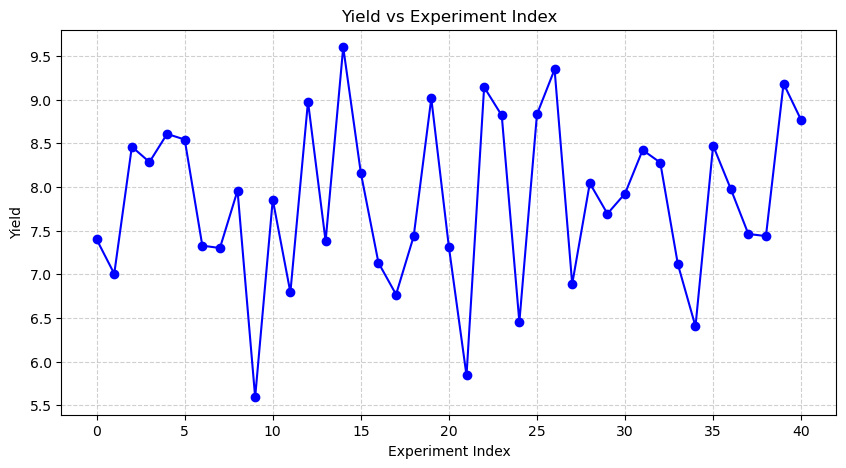

Best parameters: [0.05644741 0.06595555 0.02292868 0.03878647 0.40393544 0.80105533
 0.48830701 0.89308498]
Best yield: 9.598482002566342


In [5]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week2))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week2, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Yield')
plt.title('Yield vs Experiment Index')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week2)
best_x = inputdata_week2[best_idx]
best_y = outputdata_week2[best_idx]

print("Best parameters:", best_x)
print("Best yield:", best_y)

## Step 3: Update the surrogate model

In [6]:
X_wk2 = inputdata_week2
y_wk2 = outputdata_week2

kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(X_wk2, y_wk2)

GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=2.5),
                         normalize_y=True)

In [7]:
# Wrap prediction function for GP

def gp_predict(x1, x2, x3, x4, x5, x6, x7, x8):
    X_new = np.array([[x1, x2, x3, x4, x5, x6, x7, x8]])
    mu = gp.predict(X_new)[0]
    return mu  # maximise performance

pbounds = {
    'x1': (0, 1),
    'x2': (0, 1),
    'x3': (0, 1),
    'x4': (0, 1),
    'x5': (0, 1),
    'x6': (0, 1),
    'x7': (0, 1),
    'x8': (0, 1)
}

## Step 4: Acquisition function for updated data

In [8]:
optimizer = BayesianOptimization(
    f=gp_predict,        # surrogate function to optimise
    pbounds=pbounds,     # search space
    random_state=42,
    verbose=2
)

optimizer.maximize(
    init_points=0,       # use only model-based exploration
    n_iter=20            # suggest 10 new hyperparameter sets
)

|   iter    |  target   |    x1     |    x2     |    x3     |    x4     |    x5     |    x6     |    x7     |    x8     |
-------------------------------------------------------------------------------------------------------------------------
| 1         | 7.6717206 | 0.3745401 | 0.9507143 | 0.7319939 | 0.5986584 | 0.1560186 | 0.1559945 | 0.0580836 | 0.8661761 |
| 2         | 7.1623981 | 1.0       | 0.0       | -.400e-18 | 0.0       | 1.0       | 1.0       | 1.0       | 0.0       |
| 3         | 7.7650589 | 0.4362734 | 0.0535534 | 0.5351936 | 0.7080350 | 0.8530202 | 0.6104665 | 0.9738062 | 0.6338490 |
| 4         | 6.5517072 | 0.8302373 | 0.0022303 | 0.8410091 | 0.2668357 | 0.4449538 | 0.1748114 | 0.9143577 | 0.4281315 |
| 5         | 7.7828495 | 0.3512130 | 0.9239929 | 0.7054644 | 0.6183917 | 0.0548505 | 0.2936318 | 0.1031162 | 0.7288570 |
| 6         | 8.3842006 | 0.1677746 | 0.3880188 | 0.4407352 | 0.9457059 | 0.7866912 | 0.7381656 | 0.7029376 | 0.7920235 |
| 7         | 8.2540085 

## Step 5: Identify next logical parameters


=== Best combination found ===
Hyperparameters: {'x1': np.float64(0.0), 'x2': np.float64(0.149137), 'x3': np.float64(0.0), 'x4': np.float64(0.47311), 'x5': np.float64(0.641523), 'x6': np.float64(0.517804), 'x7': np.float64(0.0), 'x8': np.float64(0.549797)}
Predicted performance score: 9.985789


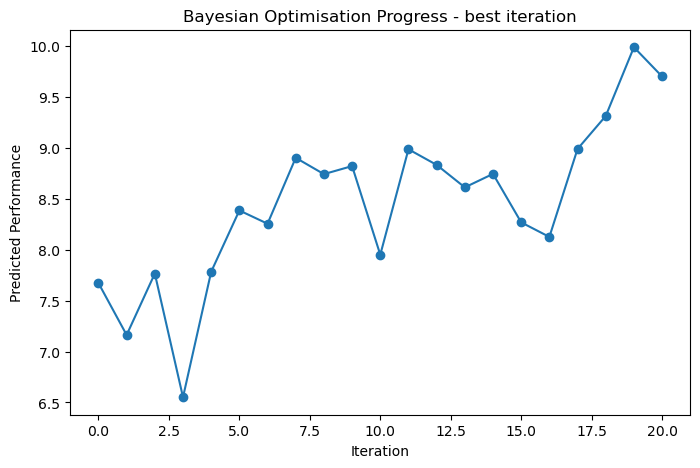

In [11]:
rounded_params = {k: round(v, 6) for k, v in optimizer.max['params'].items()}
rounded_target = round(optimizer.max['target'], 6)

print("\n=== Best combination found ===")
print("Hyperparameters:", rounded_params)
print("Predicted performance score:", rounded_target)

#Plot optimisation progress
scores = [res["target"] for res in optimizer.res]
plt.figure(figsize=(8,5))
plt.plot(scores, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Predicted Performance")
plt.title("Bayesian Optimisation Progress - best iteration")
plt.show()

# ******* Week 3: Update data for optimisation *********

### Step 1: Update data for surrogate model optimisation

In [3]:
inputdata = np.load('inputs_week2.npy')
outputdata = np.load('outputs_week2.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week2/inputs.txt', 'r') as f:
    inputs_week3 = f.read()

with open('../Inputs_Outputs/Week2/outputs.txt', 'r') as f:
    outputs_week3 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week3 = eval(inputs_week3, {"__builtins__": {}}, safe_globals)
outputs_week3 = eval(outputs_week3, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week3 = np.array(inputs_week3, dtype=object)
outputs_week3 = np.array(outputs_week3, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F8_inputs_week3 = inputs_week3[7]
F8_outputs_week3 = outputs_week3[7]

# Step 5: merge with previous data
F8_inputs_week3 = F8_inputs_week3.reshape(1, -1)
inputdata_week3 = np.concatenate((inputdata,F8_inputs_week3), axis=0)

outputdata_week3 = np.concatenate((outputdata,np.array([F8_outputs_week3])))

print(inputdata_week3)
print(outputdata_week3)

# Save outputs
np.save('inputs_week3.npy', inputdata_week3)
np.save('outputs_week3.npy', outputdata_week3)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

### Step 2: Plot the outputs of the updated data

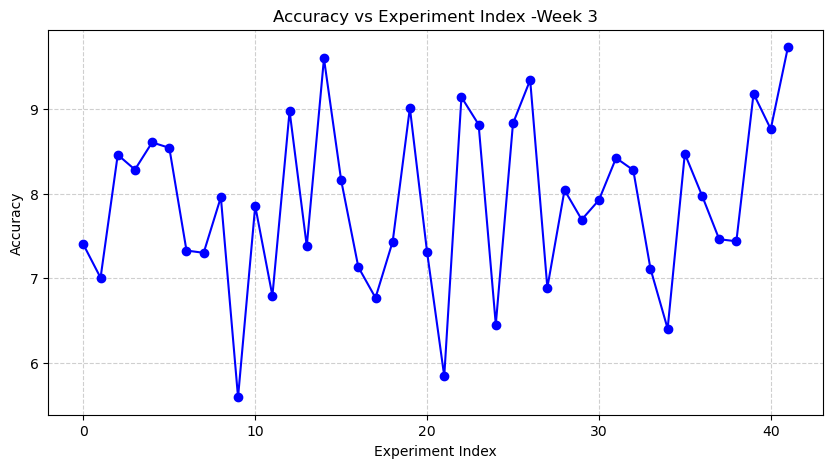

Best parameters: [0.       0.149137 0.       0.47311  0.641523 0.517804 0.       0.549797]
Best Accuracy score: 9.7317726868296


In [6]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week3))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week3, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Experiment Index -Week 3')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week3)
best_x = inputdata_week3[best_idx]
best_y = outputdata_week3[best_idx]

print("Best parameters:", best_x)
print("Best Accuracy score:", best_y)

### Step 3: Update surrogate model for Gaussian Process

In [5]:
X_wk3 = inputdata_week3
y_wk3 = outputdata_week3

kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(X_wk3, y_wk3)

GaussianProcessRegressor(kernel=Matern(length_scale=0.5, nu=2.5),
                         normalize_y=True)

### step 4: Update acquisition function

In [7]:
n_candidates = 10000  # sample many points to explore 8D space
rng = np.random.default_rng(42)
X_candidates = rng.uniform(low=0, high=1, size=(n_candidates, 8))

In [9]:
kappa = 2.0  # tradeoff: higher = more exploration, lower = more exploitation
mu, sigma = gp.predict(X_candidates, return_std=True)
UCB = mu + kappa * sigma

# Pick the candidate with highest UCB
next_idx = np.argmax(UCB)
x_next = X_candidates[next_idx]
print("Next hyperparameters to evaluate (scaled):", np.round(x_next,6))
print("Predicted UCB value:", UCB[next_idx])

Next hyperparameters to evaluate (scaled): [0.078187 0.158932 0.026599 0.138226 0.529417 0.076738 0.059868 0.118162]
Predicted UCB value: 10.53307254034244


# ****** Week 4 - Update of data ******

## Step 1: Load in new data

In [2]:
inputdata = np.load('inputs_week3.npy')
outputdata = np.load('outputs_week3.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week3/inputs.txt', 'r') as f:
    inputs_week4 = f.read()

with open('../Inputs_Outputs/Week3/outputs.txt', 'r') as f:
    outputs_week4 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week4 = eval(inputs_week4, {"__builtins__": {}}, safe_globals)
outputs_week4 = eval(outputs_week4, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week4 = np.array(inputs_week4, dtype=object)
outputs_week4 = np.array(outputs_week4, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F8_inputs_week4 = inputs_week4[7]
F8_outputs_week4 = outputs_week4[7]

# Step 5: merge with previous data
F8_inputs_week4 = F8_inputs_week4.reshape(1, -1)
inputdata_week4 = np.concatenate((inputdata,F8_inputs_week4), axis=0)

outputdata_week4 = np.concatenate((outputdata,np.array([F8_outputs_week4])))

print(inputdata_week4)
print(outputdata_week4)

# Save outputs
np.save('inputs_week4.npy', inputdata_week4)
np.save('outputs_week4.npy', outputdata_week4)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

## Step 2: Visualise the data

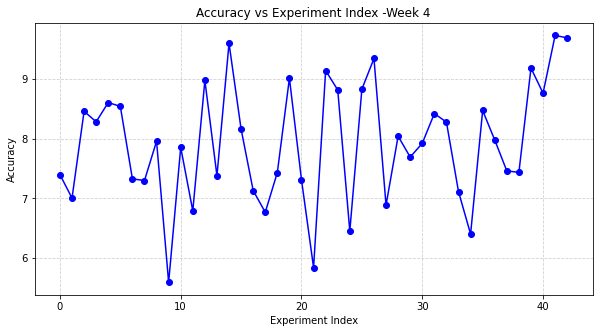

Best parameters: [0.       0.149137 0.       0.47311  0.641523 0.517804 0.       0.549797]
Best Accuracy score: 9.7317726868296


In [3]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week4))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week4, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Experiment Index -Week 4')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week4)
best_x = inputdata_week4[best_idx]
best_y = outputdata_week4[best_idx]

print("Best parameters:", best_x)
print("Best Accuracy score:", best_y)

## Step 3: Update GP moel

In [6]:
X_wk4 = inputdata_week4
y_wk4 = outputdata_week4

kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk4, y_wk4)


n_candidates = 20000
x_candidates = np.random.rand(n_candidates, 8)

mu, sigma = gp.predict(x_candidates, return_std=True)


## Step 4: Update acquisition function

In [10]:
# EI function
from scipy.stats import norm

y_max = y_wk4.max()
sigma_safe = np.copy(sigma)
sigma_safe[sigma_safe ==0] = 1e-12
z = (mu - y_max) / sigma_safe
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Choose next point to evaluate
x_next = x_candidates[np.argmax(EI)]
print("Next BO input to evaluate:", x_next)

Next BO input to evaluate: [0.26241848 0.2369394  0.07103108 0.05708545 0.59849295 0.39702624
 0.25236977 0.49553375]


# ****** Week 5: Update ******

## Step 1 : Upload data

In [2]:
inputdata = np.load('inputs_week4.npy')
outputdata = np.load('outputs_week4.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week4/inputs.txt', 'r') as f:
    inputs_week5 = f.read()

with open('../Inputs_Outputs/Week4/outputs.txt', 'r') as f:
    outputs_week5 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week5 = eval(inputs_week5, {"__builtins__": {}}, safe_globals)
outputs_week5 = eval(outputs_week5, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week5 = np.array(inputs_week5, dtype=object)
outputs_week5 = np.array(outputs_week5, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F8_inputs_week5 = inputs_week5[7]
F8_outputs_week5 = outputs_week5[7]

# Step 5: merge with previous data
F8_inputs_week5 = F8_inputs_week5.reshape(1, -1)
inputdata_week5 = np.concatenate((inputdata,F8_inputs_week5), axis=0)

outputdata_week5 = np.concatenate((outputdata,np.array([F8_outputs_week5])))

print(inputdata_week5)
print(outputdata_week5)

# Save outputs
np.save('inputs_week5.npy', inputdata_week5)
np.save('outputs_week5.npy', outputdata_week5)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

## Step 2: Visualise results

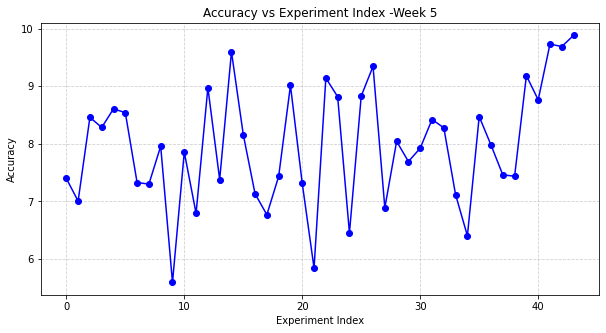

Best parameters: [0.262418 0.236939 0.071031 0.057085 0.598493 0.397026 0.252369 0.495534]
Best Accuracy score: 9.8831346516849


In [3]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week5))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week5, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Experiment Index -Week 5')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week5)
best_x = inputdata_week5[best_idx]
best_y = outputdata_week5[best_idx]

print("Best parameters:", best_x)
print("Best Accuracy score:", best_y)

## Step 3: Update GP surrogate model

In [4]:
X_wk5 = inputdata_week5
y_wk5 = outputdata_week5

kernel = Matern(length_scale=0.5, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=5, random_state=42)
gp.fit(X_wk5, y_wk5)


n_candidates = 20000
x_candidates = np.random.rand(n_candidates, 8)

mu, sigma = gp.predict(x_candidates, return_std=True)

## Step 4: Acquisition function

In [5]:
# EI function
from scipy.stats import norm

y_max = y_wk5.max()
sigma_safe = np.copy(sigma)
sigma_safe[sigma_safe ==0] = 1e-12
z = (mu - y_max) / sigma_safe
EI = (mu - y_max) * norm.cdf(z) + sigma * norm.pdf(z)
EI[sigma == 0] = 0.0

# Choose next point to evaluate
x_next = x_candidates[np.argmax(EI)]
print("Next BO input to evaluate:", x_next)

Next BO input to evaluate: [0.04970327 0.28252712 0.02184296 0.27756084 0.41084011 0.38611126
 0.25125026 0.51060738]


# **** Week 6 *****

## Step 1: Upload updated data

In [2]:
inputdata = np.load('inputs_week5.npy')
outputdata = np.load('outputs_week5.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week5/inputs.txt', 'r') as f:
    inputs_week6 = f.read()

with open('../Inputs_Outputs/Week5/outputs.txt', 'r') as f:
    outputs_week6 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week6 = eval(inputs_week6, {"__builtins__": {}}, safe_globals)
outputs_week6 = eval(outputs_week6, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week6 = np.array(inputs_week6, dtype=object)
outputs_week6 = np.array(outputs_week6, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F8_inputs_week6 = inputs_week6[7]
F8_outputs_week6 = outputs_week6[7]

# Step 5: merge with previous data
F8_inputs_week6 = F8_inputs_week6.reshape(1, -1)
inputdata_week6 = np.concatenate((inputdata,F8_inputs_week6), axis=0)

outputdata_week6 = np.concatenate((outputdata,np.array([F8_outputs_week6])))

print(inputdata_week6)
print(outputdata_week6)

# Save outputs
np.save('inputs_week6.npy', inputdata_week6)
np.save('outputs_week6.npy', outputdata_week6)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

## Step 2: Plot output data

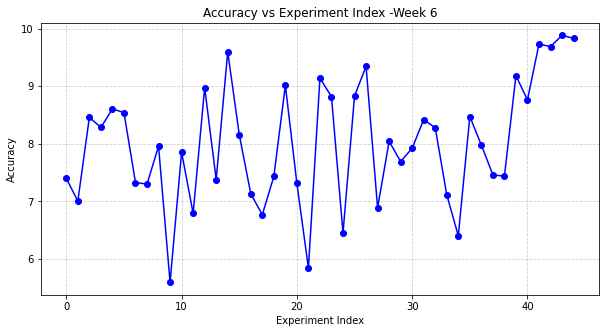

Best parameters: [0.262418 0.236939 0.071031 0.057085 0.598493 0.397026 0.252369 0.495534]
Best Accuracy score: 9.8831346516849


In [3]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week6))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week6, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Experiment Index -Week 6')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week6)
best_x = inputdata_week6[best_idx]
best_y = outputdata_week6[best_idx]

print("Best parameters:", best_x)
print("Best Accuracy score:", best_y)

### Things to resolve this week

#### 1. EI is not ideal at this level of dimensionality - worth considering a different acquisition function such as UCB
#### 2. The kernel is too smooth, it assumes all dimensions are equal but some may have greater associations to output than others 
#### 3. Need to focus on near good candidates such as trust-regions
#### 4. Candidate sampling is uniform but some hyperparameters may have very sensitive ranges. Uniform sampling wastes evaluations on unimportant regions. 

### How to improve

#### 1. Use more anisotropic kernel smoothing in lengthscale 
#### 2. Add small noise term (alpha) for numerical stability
#### 3. Use a UCB instead of EI for such high dimensions
#### 4. Focus on trust regions, identify top points and sample in local region around those.

## Step 3: Update GP with anisotropic kernel 

In [5]:
X_wk6=inputdata_week6
y_wk6=outputdata_week6

kernel = Matern(length_scale=np.ones(8)*0.5, nu=2.5)  # separate lengthscale per dimension
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True,
                              n_restarts_optimizer=10, random_state=42)
gp.fit(X_wk6, y_wk6)

/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=1e-06,
                         kernel=Matern(length_scale=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], nu=2.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=42)

## Step 4: Identify top candidates for trust region 

In [6]:
best_idx = np.argmax(y_wk6)
x_best = X_wk6[best_idx]

# Trust region radius (adjustable, start around 0.1)
radius = 0.1

# Generate candidates in local region around best point
n_candidates = 5000
x_candidates = x_best + np.random.uniform(-radius, radius, size=(n_candidates, 8))
x_candidates = np.clip(x_candidates, 0.0, 1.0)  # keep candidates in valid bounds


# Predict GP
mu, sigma = gp.predict(x_candidates, return_std=True)


## Step 5: Fit new acquisition and find candidate regions

In [7]:
kappa = 2.0  # exploration/exploitation tradeoff
UCB = mu + kappa * sigma

# Next points
x_next = x_candidates[np.argmax(UCB)]
print("Next BO input to evaluate:", np.round(x_next, 6))

Next BO input to evaluate: [0.217053 0.145341 0.1546   0.151132 0.698054 0.475479 0.192586 0.478603]


# ******* Week 7 ********

## Step 1: Upload updated data

In [2]:
inputdata = np.load('inputs_week6.npy')
outputdata = np.load('outputs_week6.npy')

#Read in text file of inputs
with open('../Inputs_Outputs/Week6/inputs.txt', 'r') as f:
    inputs_week7 = f.read()

with open('../Inputs_Outputs/Week6/outputs.txt', 'r') as f:
    outputs_week7 = f.read()

# Step 1: Define a safe namespace for eval
safe_globals = {'np': np, 'array': np.array}

# Step 2: Convert the text to actual Python objects
inputs_week7 = eval(inputs_week7, {"__builtins__": {}}, safe_globals)
outputs_week7 = eval(outputs_week7, {"__builtins__": {}}, safe_globals)

# Step 3: Optional: convert to NumPy arrays of objects
inputs_week7 = np.array(inputs_week7, dtype=object)
outputs_week7 = np.array(outputs_week7, dtype=object)

# Step 4: Select relevant data for your function. In this case we want function 1 inputs and outputs

F8_inputs_week7 = inputs_week7[7]
F8_outputs_week7 = outputs_week7[7]

# Step 5: merge with previous data
F8_inputs_week7 = F8_inputs_week7.reshape(1, -1)
inputdata_week7 = np.concatenate((inputdata,F8_inputs_week7), axis=0)

outputdata_week7 = np.concatenate((outputdata,np.array([F8_outputs_week7])))

print(inputdata_week7)
print(outputdata_week7)

# Save outputs
np.save('inputs_week7.npy', inputdata_week7)
np.save('outputs_week7.npy', outputdata_week7)

[[0.60499445 0.29221502 0.90845275 0.35550624 0.20166872 0.57533801
  0.31031095 0.73428138]
 [0.17800696 0.56622265 0.99486184 0.21032501 0.32015266 0.70790879
  0.63538449 0.10713163]
 [0.00907698 0.81162615 0.52052036 0.07568668 0.26511183 0.09165169
  0.59241515 0.36732026]
 [0.50602816 0.65373012 0.36341078 0.17798105 0.0937283  0.19742533
  0.7558269  0.29247234]
 [0.35990926 0.24907568 0.49599717 0.70921498 0.11498719 0.28920692
  0.55729515 0.59388173]
 [0.77881834 0.0034195  0.33798313 0.51952778 0.82090699 0.53724669
  0.5513471  0.66003209]
 [0.90864932 0.0622497  0.23825955 0.76660355 0.13233596 0.99024381
  0.68806782 0.74249594]
 [0.58637144 0.88073573 0.74502075 0.54603485 0.00964888 0.74899176
  0.23090707 0.09791562]
 [0.76113733 0.85467239 0.38212433 0.33735198 0.68970832 0.30985305
  0.63137968 0.04195607]
 [0.9849332  0.69950626 0.9988855  0.18014846 0.58014315 0.23108719
  0.49082694 0.31368272]
 [0.11207131 0.43773566 0.59659878 0.59277563 0.22698177 0.41010452
  

## Step 2: Visualise results

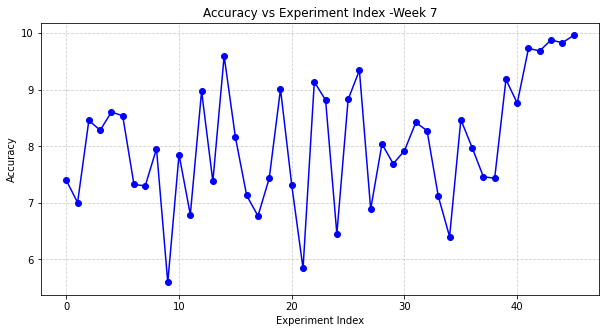

Best parameters: [0.217053 0.145341 0.1546   0.151132 0.698054 0.475479 0.192586 0.478603]
Best Accuracy score: 9.9633772918251


In [3]:
## Plot the outputs to see how it is doing
## We want to see the highest possible performance

indices = np.arange(len(outputdata_week7))

plt.figure(figsize=(10,5))
plt.plot(indices, outputdata_week7, marker='o', linestyle='-', color='blue')
plt.xlabel('Experiment Index')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Experiment Index -Week 7')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# We can see from this plot that the best yield was from parameters in index 15
best_idx = np.argmax(outputdata_week7)
best_x = inputdata_week7[best_idx]
best_y = outputdata_week7[best_idx]

print("Best parameters:", best_x)
print("Best Accuracy score:", best_y)

## Things to improve this week

### Point 1: Noise is quite low for 8D function - this could be too low for the number of observations, noisy validation accuracy.
### Fix 1: Increase noise so uncertainty is realistic so that this prevents GP from hallucinating sharp peaks and improves exploration near the trust-region boundary.

### Point 2: The GP kernel does not have any amplitude learning - this means the model can become overconfident or underconfident in different regions and acquisition functions can suffer.
### Fox 2: Add ConstantKernel this allows GP to learn whether the surface is flat or steep or how much uncertainty is plausible.

## Step 3: Update GP model

In [5]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

X_wk7 = inputdata_week7
y_wk7 = outputdata_week7


# Gaussian Process model

# Add signal variance (ConstantKernel) and realistic noise (alpha)
kernel = ConstantKernel(1.0, (1e-2, 10.0)) * Matern(
    length_scale=np.ones(8) * 0.5,
    length_scale_bounds=(1e-2, 3.0),
    nu=2.5
)

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=1e-3,               # realistic observation noise
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)

gp.fit(X_wk7, y_wk7)


/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 4 of parameter k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amyjolly/opt/anaconda3/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 5 of parameter k2__length_scale is close to the specified upper bound 3.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/amyjolly/opt/anaconda3/lib/python3.9/site-

GaussianProcessRegressor(alpha=0.001,
                         kernel=1**2 * Matern(length_scale=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5], nu=2.5),
                         n_restarts_optimizer=10, normalize_y=True,
                         random_state=42)

## Step 4: Update trust region for GP

In [6]:
best_idx = np.argmax(y_wk7)
x_best = X_wk7[best_idx]

# -----------------------------
# Trust region radius (local candidate generation)
# -----------------------------
radius = 0.1
n_candidates = 5000
x_candidates = x_best + np.random.uniform(-radius, radius, size=(n_candidates, 8))
x_candidates = np.clip(x_candidates, 0.0, 1.0)

# -----------------------------
# GP prediction
# -----------------------------
mu, sigma = gp.predict(x_candidates, return_std=True)

## Step 5: Update acquisition function and find next candidates

In [7]:
kappa = 2.0
UCB = mu + kappa * sigma

# -----------------------------
# Next point to evaluate
# -----------------------------
x_next = x_candidates[np.argmax(UCB)]
print("Next BO input to evaluate:", np.round(x_next, 6))

Next BO input to evaluate: [0.144716 0.238185 0.245948 0.073912 0.762952 0.391916 0.109778 0.57156 ]
